# readme
descrip: plot to compare volume transports along the Florida Strait between CESM-POP diagnostics outputs and my own calculation by postprocessing CESM-POP output UVEL <br>

update history: <br>
v1.0 DL 2021Oct20 <br>
v1.1 DL 2021Oct22 correct for partial bottom cell following Steve's POP_MOC (https://github.com/sgyeager/POP_MOC/blob/main/pop_moc_0p1deg.py)<br>
v1.2 DL 2021Oct24 compare with CESM-POP diagnostics outputs <br>
v1.3 DL 2021Oct26 use Sanjiv's submeso FOSI runs <br>

extra notes: <br>
CESM-POP subroutine diag_transport line# 2010-2255 at https://github.com/ESCOMP/POP2-CESM/blob/master/source/diagnostics.F90 <br>
Channel index (https://ncar.github.io/POP/doc/build/html/users_guide/model-diagnostics-and-output.html) <br>

# import modules

In [1]:
# general python packages
import numpy as np
# from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
# import cartopy
# import cartopy.crs as ccrs
# cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob
import cftime
import util

# python GCM(POP) packages
# import xgcm
# import pop_tools
# import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
# client = Client("tcp://10.73.1.1:36170")
# client

# define parameters

In [3]:
# === t12 ===
# FSm: Florida Strait Meridional section
# 292  292 1418 1443    1   42 merid  Florida Strait 
# reference: https://ncar.github.io/POP/doc/build/html/users_guide/model-diagnostics-and-output.html
ilon1_FSm_t12 = 292-1 
ilat1_FSm_t12, ilat2_FSm_t12 = 1418-1-1, 1443 
# -1 is because python index starts from 0 while Fortran index starts from 1
# CESM-POP subroutine diag_transport line # 2010-2255 at https://github.com/ESCOMP/POP2-CESM/blob/master/source/diagnostics.F90
# compute averages along nlat dim, so I read one point ahead of 1418, the two sides are on the lands (KMU=0, see codes below)
# ===========

# read files

In [4]:
# FOSI submeso UVEL HR
infile_uvel= ('/scratch/user/sanjiv/shared/dapeng/cmpr_submeso_5km.pop.h.0277-01.nc')

ds_uvel = xr.open_dataset(infile_uvel)
ds_uvel

<xarray.Dataset>
Dimensions:                 (d2: 2, nlat: 2400, nlon: 3600, time: 1, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time                    (time) object 0277-02-01 00:00:00
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 ... 5.5e+05 5.75e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.75e+05 6e+05
    ULONG                   (nlat, nlon) float64 ...
    ULAT                    (nlat, nlon) float64 ...
    TLONG                   (nlat, nlon) float64 ...
    TLAT                    (nlat, nlon) float64 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/104)
    time_bound              (time, d2) object ...
    dz                      (z_t) float32 ...
    dzw                     (z_w) float32 ...
    KMT                     (nlat, nlon) float64 ...
    KMU                     (nlat, nlon) float64 ...
    REGION_MASK             (nlat, nlon) float64 ...
    ...                      ...
    QFLUX                   (time, nlat, nlon) float32 ...
    HMXL                    (time, nlat, nlon) float32 ...
    XMXL                    (time, nlat, nlon) float32 ...
    TMXL                    (time, nlat, nlon) float32 ...
    XBLT                    (time, nlat, nlon) float32 ...
    TBLT                    (time, nlat, nlon) float32 ...
Attributes:
    title:             submeso_5km
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 90507 2019-01-18 20:54:19Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-10-12 at 11:12:33.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [5]:
# CESM-POP diagnostic transport (dt)
infile_dt = ('/scratch/user/sanjiv/shared/dapeng/submeso_5km.pop.dt.0277-01-01-00000')
colnames=['time', 'Qv', 'Qh', 'Qs','channel_name'] 
df = pd.read_csv(infile_dt, sep='  ', engine='python',  usecols=[0,1,2,3,4], 
                header=None, skiprows=[0], names=colnames, index_col=[0]) 
df

,Qv,Qh,Qs,channel_name
time,,,,
100741.0,112.455000,1.347594,3867.970000,ACC-Drake
100741.0,24.560650,1.975579,884.891800,Florida Strait
100741.0,21.261110,1.744148,766.506900,Yucatan Passage (Zonal)
100741.0,-1.521224,-0.148851,-55.186460,Yucatan Passage (Merid)
100741.0,1.652877,0.103464,59.213100,Jamaica Channel
...,...,...,...,...
101470.0,0.917102,0.077417,31.781070,Ohsumi Strait
101470.0,0.553995,0.042206,18.961090,Southern Korea Strait
101470.0,0.811493,0.052175,27.456890,Northern Korea Strait


# data analysis

In [6]:
# Compute 3D DZU with partial bottom cell corrected, copied from Steve's github 
# (https://github.com/sgyeager/POP_MOC/blob/main/pop_moc_0p1deg.py) 
# and commented a few lines. Need a POP history file for 3D DZU
in_file = infile_uvel

ds = xr.open_dataset(in_file)
pd     = ds['PD']
pd=pd.drop(['ULAT','ULONG'])            # this is a python bug that we are correcting
temp   = ds['TEMP']
temp=temp.drop(['ULAT','ULONG'])
# salt   = ds['SALT']
# salt=salt.drop(['ULAT','ULONG'])
# u_e   = ds['UVEL']/100
# u_e=u_e.drop(['TLAT','TLONG'])
# u_e.attrs['units']='m/s'
# v_e   = ds['VVEL']/100
# v_e=v_e.drop(['TLAT','TLONG'])
# v_e.attrs['units']='m/s'
# w_e   = ds['WVEL']/100
# w_e=w_e.drop(['ULAT','ULONG'])
# w_e.attrs['units']='m/s'
ulat   = ds['ULAT']
ulon   = ds['ULONG']
tlat   = ds['TLAT']
tlon   = ds['TLONG']
kmt  = ds['KMT']
kmt.values[np.isnan(kmt.values)]=0	# get rid of _FillValues
kmu  = ds['KMU']
kmu.values[np.isnan(kmu.values)]=0	# get rid of _FillValues
dxu    = ds['DXU']/100
dxu.attrs['units']='m'
dyu    = ds['DYU']/100
dyu.attrs['units']='m'
rmask  = ds['REGION_MASK']
tarea  = ds['TAREA']/100/100
tarea.attrs['units']='m^2'
uarea  = ds['UAREA']/100/100
uarea.attrs['units']='m^2'
time   = ds['time']
time.encoding['_FillValue']=None    
z_t   = ds['z_t']/100
z_t.attrs['units']='m'
z_w   = ds['z_w']/100
z_w.attrs['units']='m'
z_w_bot   = ds['z_w_bot']/100
z_w_bot.attrs['units']='m'
dz   = ds['dz']/100
dz.attrs['units']='m'
dzw   = ds['dzw']/100
dzw.attrs['units']='m'
hu   = ds['HU']/100
hu.attrs['units']='m'
ht   = ds['HT']/100
ht.attrs['units']='m'
dims = np.shape(temp)
nt = dims[0]
nz = dims[1]
ny = dims[2]
nx = dims[3]
km = int(np.max(kmt).values)
mval=pd.encoding['_FillValue']

# Create a k-index array for masking purposes
kji = np.indices((nz,ny,nx))
kindices = kji[0,:,:,:] + 1

# Define top/bottom depths of POP T-grid
z_bot=z_w.values
z_bot=z_w.values+dz.values
z_top=z_w.values

# Compute PBC from grid info:
dzt = util.pbc_dzt(dz,kmt,ht,z_w_bot,mval)

# Regrid PBC thicknesses to U-grid
tmp=dzt
tmpe=tmp.roll(nlon=-1,roll_coords=False)        # wraparound shift to west, without changing coords
tmpn=tmp.shift(nlat=-1)                         # shift to south, without changing coords
tmpne=tmpn.roll(nlon=-1,roll_coords=False)      # wraparound shift to west, without changing coords
tmpall=xr.concat([tmp,tmpe,tmpn,tmpne],dim='dummy')
dzu=tmpall.min('dummy')
dzu.attrs['units'] = 'm'
del tmp,tmpe,tmpn,tmpne,tmpall

dzu # 3D DZU with partial bottom cell corrected

<xarray.DataArray (z_t: 62, nlat: 2400, nlon: 3600)>
array([[[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        ...,
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36]],

       [[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
...
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36]],

       [[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        ...,
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36]]])
Dimensions without coordinates: z_t, nlat, nlon
Attributes:
    units:    m

In [7]:
# compute kmu
kmu_FSm = ds_uvel.KMU.isel(nlon=ilon1_FSm_t12, 
                           nlat=slice(ilat1_FSm_t12, ilat2_FSm_t12)).values
kmu_FSm # two sides are land points, kMU=0

array([ 0.,  0.,  0.,  3.,  3., 28., 39., 41., 41., 41., 42., 41., 40.,
       39., 38., 36., 29., 23., 19., 12.,  3.,  3.,  3.,  3.,  3.,  0.,
        0.])

In [8]:
# compute dyu
dyu_FSm = ds_uvel.DYU.isel(nlon=ilon1_FSm_t12, 
                           nlat=slice(ilat1_FSm_t12, ilat2_FSm_t12)).values/100 # unit: m 
dyu_FSm

array([10247.14164119, 10240.1905632 , 10233.21772814, 10226.22322298,
       10219.20713439, 10212.16954911, 10205.11055467, 10198.03023846,
       10190.92868756, 10183.80598958, 10176.66223205, 10169.4975026 ,
       10162.31188918, 10155.10547988, 10147.87836248, 10140.63062509,
       10133.36235593, 10126.07364337, 10118.76457569, 10111.43524151,
       10104.08572937, 10096.71612772, 10089.32652538, 10081.91701129,
       10074.48767435, 10067.0386031 , 10059.56988696])

In [9]:
# compute dzu
dzu_FSm = dzu.isel(nlon=ilon1_FSm_t12, 
                   nlat=slice(ilat1_FSm_t12, ilat2_FSm_t12))
dzu_FSm

<xarray.DataArray (z_t: 62, nlat: 27)>
array([[9.96920997e+36, 9.96920997e+36, 1.00000000e+01, ...,
        1.00000000e+01, 1.00000000e+01, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36, 1.00000000e+01, ...,
        1.00000000e+01, 1.00000000e+01, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36, 1.00000000e+01, ...,
        1.00000000e+01, 1.00000000e+01, 9.96920997e+36],
       ...,
       [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
        9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
        9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
        9.96920997e+36, 9.96920997e+36, 9.96920997e+36]])
Dimensions without coordinates: z_t, nlat
Attributes:
    units:    m

CPU times: user 365 ms, sys: 24.7 ms, total: 389 ms
Wall time: 389 ms


<xarray.DataArray 'UVEL' (time: 1, z_t: 62, nlat: 27)>
array([[[      nan,       nan,       nan, ..., 15.036187,       nan,
               nan],
        [      nan,       nan,       nan, ..., 17.287008,       nan,
               nan],
        [      nan,       nan,       nan, ..., 17.52273 ,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) object 0277-02-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat) float64 -80.8 -80.8 -80.8 -80.8 ... -80.8 -80.8 -80.8 -80.8
    ULAT     (nlat) float64 22.87 22.96 23.06 23.15 ... 24.97 25.06 25.16 25.25
    TLONG    (nlat) float64 279.1 279.1 279.1 279.1 ... 279.1 279.1 279.1 279.1
    TLAT     (nlat) float64 22.83 22.92 23.01 23.1 ... 24.93 25.02 25.11 25.2
Dimensions without coordinates: nlat
Attributes:
    long_name:     Velocity in grid-x direction
    units:         centimeter/s
    grid_loc:      3221
    cell_methods:  time: mean

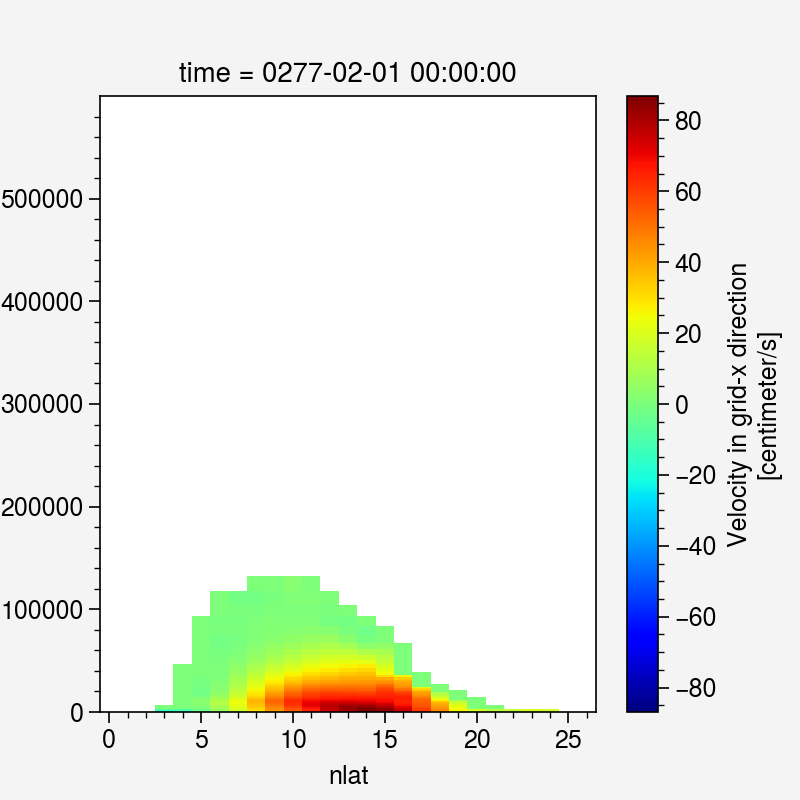

In [10]:
%%time
u_FSm = ds_uvel.UVEL.isel(nlon=ilon1_FSm_t12, nlat=slice(ilat1_FSm_t12, ilat2_FSm_t12)
                    ).compute().where(kmu_FSm>0, np.nan) # mask land points 
u_FSm.plot(cmap='jet') # land points are nan
u_FSm

In [11]:
Q_FSm = (u_FSm/100*dyu_FSm*dzu_FSm).fillna(0) # Q is flux, fill land with 0 before computing sum
Q_FSm

<xarray.DataArray (time: 1, z_t: 62, nlat: 27)>
array([[[    0.        ,     0.        ,     0.        , ...,
         15148.1876328 ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
         17415.77537003,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
         17653.25267335,     0.        ,     0.        ],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ]]])
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * time     (time) object 0277-02-01 00:00:00
    ULONG    (nlat) float64 -80.8 -80.8 -80.8 -80.8 ... -80.8 -80.8 -80.8 -80.8
    ULAT     (nlat) float64 22.87 22.96 23.06 23.15 ... 24.97 25.06 25.16 25.25
    TLONG    (nlat) float64 279.1 279.1 279.1 279.1 ... 279.1 279.1 279.1 279.1
    TLAT     (nlat) float64 22.83 22.92 23.01 23.1 ... 24.93 25.02 25.11 25.2
Dimensions without coordinates: nlat

In [12]:
Q_FSm_av = (Q_FSm[:,:,0:-1] + Q_FSm[:,:,1:])/2
# compute mean along nlat dim following line 2103-2109 at https://github.com/ESCOMP/POP2-CESM/blob/master/source/diagnostics.F90
Q_FSm_sum = Q_FSm_av.sum('z_t').sum('nlat')/1e6 # convert unit to Sv
Q_FSm_sum # Flux from my postprocessing scripts

<xarray.DataArray (time: 1)>
array([24.09754672])
Coordinates:
  * time     (time) object 0277-02-01 00:00:00

In [13]:
nchannel = 141
ds1_FSm = df.iloc[1::nchannel,:].to_xarray() # Florida Strait
ds1_FSm

<xarray.Dataset>
Dimensions:       (time: 730)
Coordinates:
  * time          (time) float64 1.007e+05 1.007e+05 ... 1.015e+05 1.015e+05
Data variables:
    Qv            (time) float64 24.56 23.89 23.31 23.87 ... 25.02 25.07 24.33
    Qh            (time) float64 1.976 1.932 1.886 1.926 ... 2.174 2.156 2.084
    Qs            (time) float64 884.9 861.2 840.5 860.5 ... 901.8 903.2 876.4
    channel_name  (time) object 'Florida Strait' ... 'Florida Strait'

In [14]:
ds1_FSm.Qv.isel(time=slice(0,31)) # the first 31 days fpr Jan mean

<xarray.DataArray 'Qv' (time: 31)>
array([24.56065, 23.88665, 23.30906, 23.87327, 24.31984, 24.24294,
       24.83622, 24.46508, 23.49437, 24.97359, 23.35883, 24.58728,
       23.25071, 21.53408, 22.22968, 22.82094, 22.38596, 23.60693,
       24.35906, 25.39878, 25.84023, 26.167  , 26.73478, 25.76054,
       25.73169, 25.81752, 24.64101, 23.50655, 24.77027, 24.24322,
       25.1957 ])
Coordinates:
  * time     (time) float64 1.007e+05 1.007e+05 ... 1.008e+05 1.008e+05

In [15]:
ds1_FSm.Qv.isel(time=slice(0,31)).mean('time') 

<xarray.DataArray 'Qv' ()>
array(24.31943323)